In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run 'req_analysis/neptune-util.py'
%env NEPTUNE_CLUSTER_ENDPOINT=ec2-18-224-170-154.us-east-2.compute.amazonaws.com
%env NEPTUNE_CLUSTER_PORT=8182
g = neptune.graphTraversal()

env: NEPTUNE_CLUSTER_ENDPOINT=ec2-18-224-170-154.us-east-2.compute.amazonaws.com
env: NEPTUNE_CLUSTER_PORT=8182
gremlin: ws://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:8182/gremlin


In [3]:
import random

In [4]:
import scipy
import scipy.spatial.distance as ssd

In [5]:
from paris import paris
from paris.utils import *

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

In [7]:
import time

from req_analysis import Requirement

In [8]:
from SPARQLWrapper import SPARQLWrapper, JSON

sparql = SPARQLWrapper("http://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:3001/sparql")

In [9]:
queryString = """prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix xml: <http://www.w3.org/XML/1998/namespace/>
prefix mms-ontology: <https://opencae.jpl.nasa.gov/mms/rdf/ontology/>
prefix mms-graph: <https://opencae.jpl.nasa.gov/mms/rdf/graph/>
prefix mms-property: <https://opencae.jpl.nasa.gov/mms/rdf/property/>
prefix mms-class: <https://opencae.jpl.nasa.gov/mms/rdf/class/>
prefix mms-element: <https://opencae.jpl.nasa.gov/mms/rdf/element/>
prefix mms-artifact: <https://opencae.jpl.nasa.gov/mms/rdf/artifact/>
prefix mms-index: <https://opencae.jpl.nasa.gov/mms/rdf/index/>
prefix xmi: <http://www.omg.org/spec/XMI/20131001#>
prefix uml: <http://www.omg.org/spec/UML/20161101#>
prefix uml-model: <https://www.omg.org/spec/UML/20161101/UML.xmi#>
prefix uml-primitives: <https://www.omg.org/spec/UML/20161101/PrimitiveTypes.xmi#>
prefix uml-class: <https://opencae.jpl.nasa.gov/mms/rdf/uml-class/>
prefix uml-property: <https://opencae.jpl.nasa.gov/mms/rdf/uml-property/>

select * from mms-graph:data.tmt {
    ?subject ?edge ?str .

    values ?edge {
        mms-property:bodyStringFromComment
        mms-property:valueString
    }
    
    filter(contains(?str, "REQ-") && strlen(?str) > 20)
    # filter(isLiteral(?str) && ?str != "")
    
    values ?subject { mms-element:_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring }
}
"""

In [10]:
queryElements = """prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix xml: <http://www.w3.org/XML/1998/namespace/>
prefix mms-ontology: <https://opencae.jpl.nasa.gov/mms/rdf/ontology/>
prefix mms-graph: <https://opencae.jpl.nasa.gov/mms/rdf/graph/>
prefix mms-property: <https://opencae.jpl.nasa.gov/mms/rdf/property/>
prefix mms-class: <https://opencae.jpl.nasa.gov/mms/rdf/class/>
prefix mms-element: <https://opencae.jpl.nasa.gov/mms/rdf/element/>
prefix mms-artifact: <https://opencae.jpl.nasa.gov/mms/rdf/artifact/>
prefix mms-index: <https://opencae.jpl.nasa.gov/mms/rdf/index/>
prefix xmi: <http://www.omg.org/spec/XMI/20131001#>
prefix uml: <http://www.omg.org/spec/UML/20161101#>
prefix uml-model: <https://www.omg.org/spec/UML/20161101/UML.xmi#>
prefix uml-primitives: <https://www.omg.org/spec/UML/20161101/PrimitiveTypes.xmi#>
prefix uml-class: <https://opencae.jpl.nasa.gov/mms/rdf/uml-class/>
prefix uml-property: <https://opencae.jpl.nasa.gov/mms/rdf/uml-property/>

select * from mms-graph:data.tmt {
    ?element a/rdfs:subClassOf* uml-class:Class
    {
        ?element rdfs:label ?label 
    } union {
        ?element mms-property:name ?label
    }
    
    filter(isLiteral(?label) && ?label != "")
}
"""

In [11]:
sparql.setQuery(queryElements)

sparql.setReturnFormat(JSON)
el_results = sparql.query().convert()

In [12]:
model_elements = []
for result in el_results["results"]["bindings"]:
#     print(result['element']['value'], result['label']['value'])
    model_elements.append(dict(uri=result['element']['value'], name=result['label']['value']))

In [13]:
sparql.setQuery(queryString)

sparql.setReturnFormat(JSON)
results = sparql.query().convert()



## Gremlin queries:
g.V('_16785_7fb36acc-eea1-4ebd-adb5-646dabb347e5').valueMap(True).toList()[0] \
keys: T.id, T.label, '_label'

In [15]:
for result in results["results"]["bindings"]:
#     if str.startswith(result["str"]["value"], "<html>"):
    req_object = Requirement(result["subject"]["value"], result["str"]["value"])
    matches = req_object.match_req_tokens(model_elements, 0.0030)
    if len(matches):
        print('Req ID: ', result["subject"]["value"], '\nReq text:' , (result["str"]["value"]))
        print(matches, '\n___________')
        break

Req ID:  https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311-slotvalue-0-literalstring 
Req text: <html><body>
<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or more Programmable Logic Controllers (PLCs), it will interface with connected subsystems via a dedicated safety rated fieldbus based on EtherNet/IP; monitor interlock requests an

In [16]:
g = neptune.graphTraversal()
req_object.init_match_subgraph(g)

gremlin: ws://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:8182/gremlin
0 1
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b', 'name': 'Data Management System'}
FAILURE in  1.7334558963775635 s:  
_________
0 2
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472', 'name': 'Data Management System'}
FAILURE in  2.593744993209839 s:  
_________
0 3
{'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'} {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999', 'name': 'Executive Software'}

SUCCESS in  0.392134

In [150]:
g = neptune.graphTraversal()
g.V('MMS_1461009357890_d8449449-d16f-43c7-90a4-ee5744566f84').repeat(both().simplePath()).until(hasId('MMS_1461009332936_4f59edac-f8f9-47e6-972b-fb68ca0f56ed').or_().loops().is_(8)).path().limit(1).toList()

gremlin: ws://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:8182/gremlin


[path[v[MMS_1461009357890_d8449449-d16f-43c7-90a4-ee5744566f84], v[_17_0_1_232f03dc_1325612611695_581988_21583], v[MMS_1461009332936_4f59edac-f8f9-47e6-972b-fb68ca0f56ed]]]

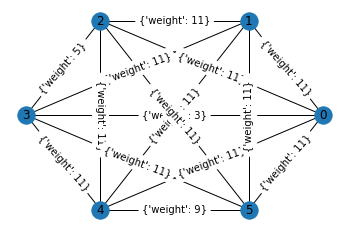

In [17]:
pos = nx.circular_layout(req_object.req_subgraph)
nx.draw_networkx_edge_labels(req_object.req_subgraph, pos)
nx.draw_circular(req_object.req_subgraph, with_labels=True)

In [32]:
match_clusters = req_object.match_clustering()

[[ 0.  3.  3.  2.]
 [ 2.  6.  5.  3.]
 [ 4.  5.  9.  2.]
 [ 1.  7. 11.  4.]
 [ 8.  9. 11.  6.]]
[[0, 3], [1], [2], [4], [5]]


### All matches:

In [33]:
for i in range(6):
    print(print(req_object.req_subgraph.nodes(data=True)[i]))

{'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}
None
{'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}
None
{'token': {'text': 'the Data Management System', 'pos': 'PROPN', 'token_id': 117}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472', 'name': 'Data Management System'}, 'score': 0.0013642900507215298}
None
{'token': {'text': 'Executive Software', 'pos': 'PROPN', 'token_id': 124}, 'model_element': {'uri': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_

### Matches within the biggest cluster:

In [34]:
for node_i in match_clusters[0]:
    print(req_object.req_subgraph.nodes(data=True)[node_i]['token']['text'], req_object.req_subgraph.nodes(data=True)[node_i]['model_element']['uri'])

the Data Management System https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095
Executive Software https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999


## Misc Testing

In [102]:
summit='_4663af6e-6265-438d-87b8-74e1550518bf__65_6314a138-53b9-42a5-b488-9c23967ed889'
enclosure='_18_0_6_f1d0357_1490143302007_461579_179266'
mirror='_18_5_2_e64033a_1509475358071_810923_58742'
aps_user='_17_0_2_3_41e01aa_1389730769202_855584_72742'
aps_mission='_17_0_2_3_41e01aa_1389728637481_651557_61606'

In [ ]:
g = neptune.graphTraversal()
g.V('_18_5_3_e64033a_1517517345905_946202_22722').repeat(both().simplePath()).until(hasId('_4663af6e-6265-438d-87b8-74e1550518bf__10_a7ad0d07-fa64-40e7-a266-db3006b20dc5').or_().loops().is_(8)).path().limit(1).toList()

In [119]:
g = neptune.graphTraversal()
g.V(enclosure).valueMap().toList()

gremlin: ws://ec2-18-224-170-154.us-east-2.compute.amazonaws.com:8182/gremlin


[{'_label': ['Enclosure']}]

In [57]:
import spacy

nlp_np = spacy.load("en_core_web_sm")
merge_nps = nlp_np.create_pipe("merge_noun_chunks")
nlp_np.add_pipe(merge_nps)


In [69]:
for t in nlp_np("Hello my name is the beautiful car of New York. Bye!"):
    print(t.text, t.pos_, t.idx)

Hello INTJ 0
my name NOUN 6
is AUX 14
the beautiful car NOUN 17
of ADP 35
New York PROPN 38
. PUNCT 46
Bye INTJ 48
! PUNCT 51
